# Model

In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
enable_float64 = True
from jax.config import config
config.update("jax_enable_x64", enable_float64)
# config.update("jax_debug_nans", True)
import json_tricks as json
import copy

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import stein
import kernels
from svgd import SVGD

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
d = dict()

In [3]:
def plot_rundata(true, *args, labels=None, ax=None, title=None):
    ax = plt.gca() if ax is None else ax
    colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    styles = ["-", "--", "-.", ":"]
    for data, label, style in zip(args, labels, styles):
        ax.set_prop_cycle(color=colorcycle)
        ax.plot(data, style, label=label)
        length = len(data)

    # True parameters
    _ = ax.hlines(true, 0, length, colors=colorcycle, linestyles="dotted")
    ax.legend()
    ax.set_title(title)

## Vanilla ARD

In [4]:
conf = copy.deepcopy(config.config)
conf["svgd"]["target_args"] = [[0, 5], [1, 3]]

conf["svgd"]["n_particles"] = 6000
conf["svgd"]["n_subsamples"] = 100

conf["train_kernel"]["train"] = False
conf["train_kernel"]["svgd_steps"] = 1
conf["train_kernel"]["n_iter"] = 80 #config.config["train_kernel"]["n_iter"] // conf_mlp["train_kernel"]["svgd_steps"]

In [5]:
svgd_vanilla = SVGD(**config.get_svgd_args(conf))
key, subkey = random.split(key)
rundata_vanilla = svgd_vanilla.sample(subkey, **config.get_sample_args(conf))

t_mean = onp.array(rundata_vanilla["leader_mean"])
t_var = onp.array(rundata_vanilla["leader_var"])
v_mean = onp.array(rundata_vanilla["validation_mean"])
v_var = onp.array(rundata_vanilla["validation_var"])
tru_mean = conf["svgd"]["target_args"][0]
tru_var = conf["svgd"]["target_args"][1]# if conf_mlp["svgd"]["target_args"][1].shape == (2,2) else diag(conf_mlp["svgd"]["target_args"][1])

100%|██████████| 80/80 [01:30<00:00,  1.14s/it]


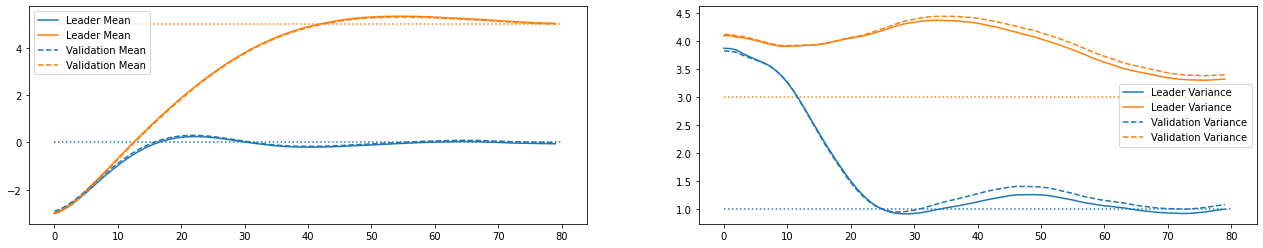

In [7]:
fig, axs = plt.subplots(1, 2, figsize=[22, 4])
plot_rundata(tru_mean, t_mean, v_mean, labels=["Leader Mean", "Validation Mean"], ax=axs[0])
plot_rundata(tru_var, t_var, v_var, labels=["Leader Variance", "Validation Variance"], ax=axs[1])

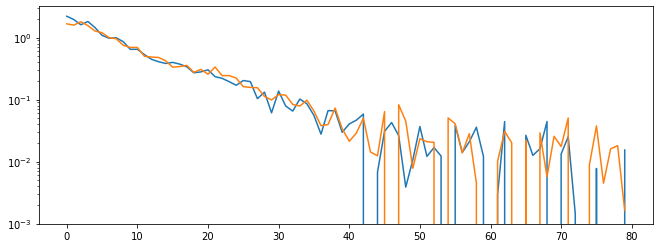

In [8]:
fig, ax = plt.subplots(figsize=[11, 4])
ax.plot(rundata_vanilla["ksd_after_svgd_update"])
ax.plot(rundata_vanilla["ksd_after_svgd_update_val"])
ax.set_yscale("log")

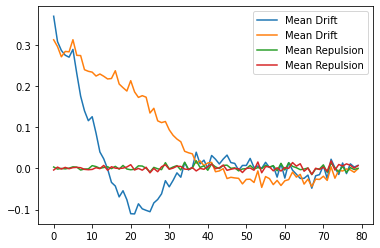

In [9]:
plt.plot(rundata_vanilla["mean_drift"], label="Mean Drift")
plt.plot(rundata_vanilla["mean_repulsion"], label="Mean Repulsion")
plt.legend()

In [9]:
# plot.bivariate_hist(rundata_vanilla["particles"])

In [10]:
### plot errorbars cts

# t_mean = onp.array(rundata_vanilla["training_mean"])
# t_var = onp.array(rundata_vanilla["training_var"])
# v_mean = onp.array(rundata_vanilla["validation_mean"])
# v_var = onp.array(rundata_vanilla["validation_var"])
# tru_mean = conf["svgd"]["target_args"][0]
# tru_var = conf["svgd"]["target_args"][1]# if conf_mlp["svgd"]["target_args"][1].shape == (2,2) else diag(conf_mlp["svgd"]["target_args"][1])
# grid = np.arange(len(t_mean))

# # fig, ax = plt.subplots(1,2, figsize=[14, 4])

# def plot_mean_and_var(mean, var, tru_mean, tru_var, ax=None):
#     colorcycle = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
#     ax = ax if ax is not None else plt.gca()
#     for i in range(2):
#         plot.errorfill(grid, mean[:, i], np.sqrt(var[:, i]), color=next(colorcycle), ax=ax)
#         ax.errorbar(len(t_mean), tru_mean[i], np.sqrt(tru_var[i]), marker="o", capsize=5)

# fig, axs = plt.subplots(1, 2, figsize=[14, 4])
# for m, v, ax, title in zip((t_mean, v_mean), (t_var, v_var), axs, ("Training", "Validation")):
#     plot_mean_and_var(m, v, tru_mean, tru_var, ax)
#     ax.set_title(title)

# MLP Kernel

In [11]:
conf_mlp = copy.deepcopy(config.config)

conf_mlp["svgd"]["target_args"] = [[0, 5], [1, 3]]

conf_mlp["svgd"]["n_particles"] = 6000
conf_mlp["svgd"]["n_subsamples"] = 100
conf_mlp["svgd"]["lam"] = 1
conf_mlp["svgd"]["encoder_layers"] = [8, 8, 8, 2]
conf_mlp["svgd"]["decoder_layers"] = [8, 8, 4, 1]

conf_mlp["train_kernel"]["ksd_steps"] = 5
conf_mlp["train_kernel"]["svgd_steps"] = 1
conf_mlp["train_kernel"]["n_iter"] = 80 #config.config["train_kernel"]["n_iter"] // conf_mlp["train_kernel"]["svgd_steps"]
conf_mlp["train_kernel"]["optimizer_ksd_args"] = [0.03]
conf_mlp["train_kernel"]["lamda_reg"] = 1e-2

In [12]:
svgd_mlp = SVGD(**config.get_svgd_args(conf_mlp))

/home/lauro/code/msc-thesis/svgd/config.py:82: UserWarning: The size of the last layer of the decoder must equalthe target particle dimension d={kwargs['target'].d}.Instead received layer size {svgd_config["decoder_layers"][-1]}. I'mmodifying the last decoder layer so that it fits.
  warnings.warn(f"The size of the last layer of the decoder must equal"


In [13]:
train_args = config.get_train_args(conf_mlp)
key, subkey = random.split(key)
encoder_params_mlp, rundata_mlp = svgd_mlp.train_kernel(key, **train_args)

100%|██████████| 80/80 [02:50<00:00,  2.13s/it]


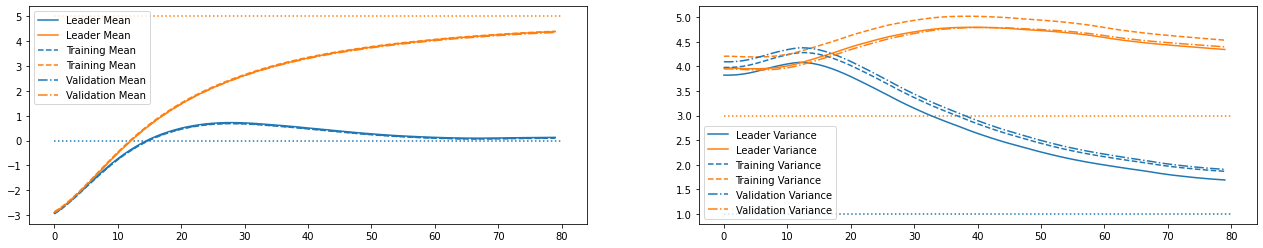

In [14]:
t_mean = onp.array(rundata_mlp["training_mean"])
v_mean = onp.array(rundata_mlp["validation_mean"])
l_mean = onp.array(rundata_mlp["leader_mean"])

v_var = onp.array(rundata_mlp["validation_var"])
t_var = onp.array(rundata_mlp["training_var"])
l_var = onp.array(rundata_mlp["leader_var"])

tru_mean = conf_mlp["svgd"]["target_args"][0]
tru_var = conf_mlp["svgd"]["target_args"][1]# if conf_mlp["svgd"]["target_args"][1].shape == (2,2) else diag(conf_mlp["svgd"]["target_args"][1])

fig, axs = plt.subplots(1, 2, figsize=[22, 4])
plot_rundata(tru_mean, l_mean, t_mean, v_mean, labels=[c + " Mean" for c in ("Leader", "Training", "Validation")], ax=axs[0])
plot_rundata(tru_var, l_var, t_var, v_var, labels=[c + " Variance" for c in ("Leader", "Training", "Validation")], ax=axs[1])

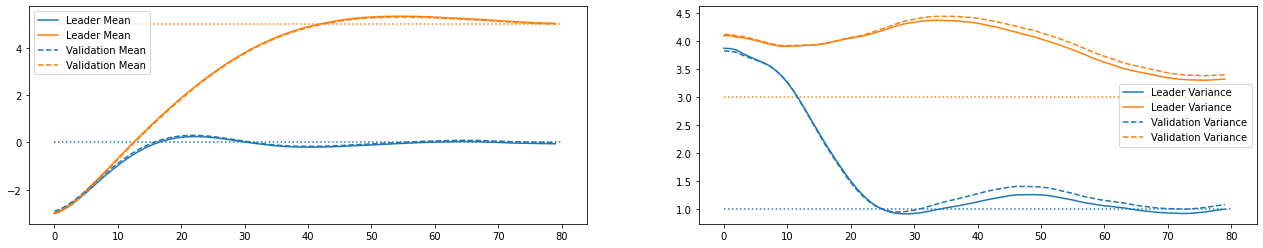

In [7]:
# vanilla
fig, axs = plt.subplots(1, 2, figsize=[22, 4])
plot_rundata(tru_mean, t_mean, v_mean, labels=["Leader Mean", "Validation Mean"], ax=axs[0])
plot_rundata(tru_var, t_var, v_var, labels=["Leader Variance", "Validation Variance"], ax=axs[1])

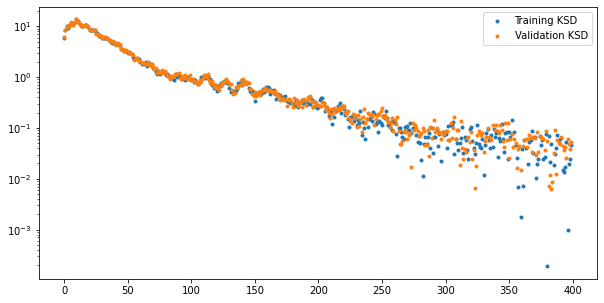

In [16]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(rundata_mlp["ksd_before_kernel_update"], ".", label="Training KSD")
ax.plot(rundata_mlp["ksd_before_kernel_update_val"], ".", label="Validation KSD")
# ax.plot(rundata_mlp["ksd_after_svgd_update"], ".", label="KSD after SVGD step")
ax.set_yscale("log")
_ = ax.legend()

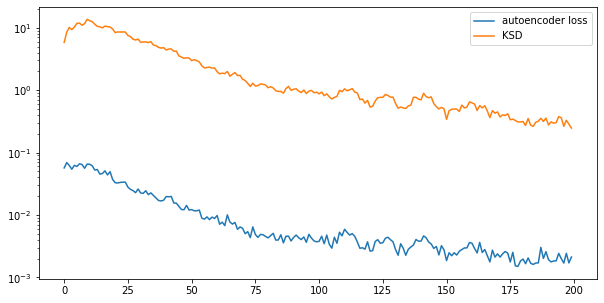

In [17]:
fig, ax = plt.subplots(figsize=[10, 5])
section = list(range(0, 200))
ax.plot(section, rundata_mlp["autoencoder_loss"][section] * train_args["lambda_reg"], label="autoencoder loss")
# ax.plot(section, rundata_mlp["regularized_loss"][section], label="Total loss = autoencoder - KSD")
ax.plot(section, rundata_mlp["ksd_before_kernel_update"][section], label="KSD")
ax.legend()
ax.set_yscale("log")

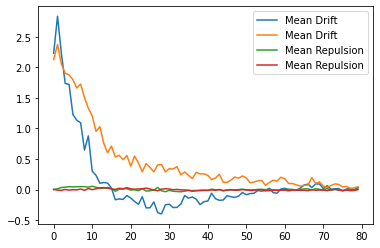

In [18]:
plt.plot(rundata_mlp["mean_drift"], label="Mean Drift")
plt.plot(rundata_mlp["mean_repulsion"], label="Mean Repulsion")
plt.legend()

## update-to-weight-ratio

In [19]:
def plot_update_to_weight_ratio(update_to_weight_ratio, scale="log"):
    con = update_to_weight_ratio
    def visit(d, prefix=""):
        for k, v in d.items():
            if type(v) is jax.interpreters.xla.DeviceArray or type(v) is onp.ndarray or type(v) is list:
                plt.plot(v, label=prefix+"//"+k)
            else:
                visit(v, k)
    visit(con)
    plt.yscale(scale)
    plt.legend()

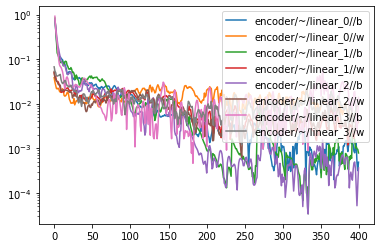

In [20]:
plot_update_to_weight_ratio(rundata_mlp["update_to_weight_ratio"])

## encoded / decoded

In [21]:
def enc(x): return svgd_mlp.encoder.apply(encoder_params_mlp, None, x)
def dec(x): return svgd_mlp.decoder.apply(rundata_mlp["decoder_params"], None, x)

In [22]:
sample = svgd_mlp.target.sample(1000)
out = vmap(enc)(sample)
recoded = vmap(dec)(out)

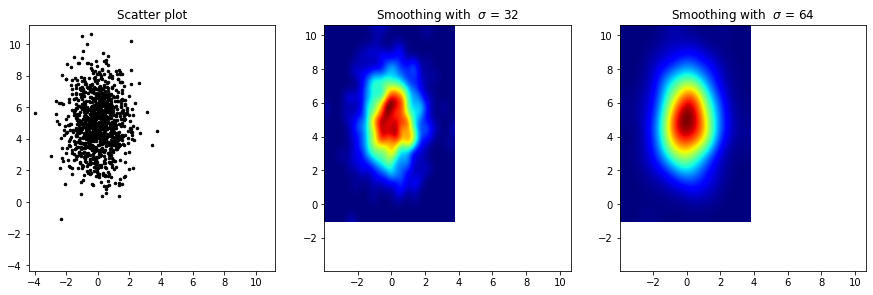

In [23]:
plot.bivariate_hist(sample)

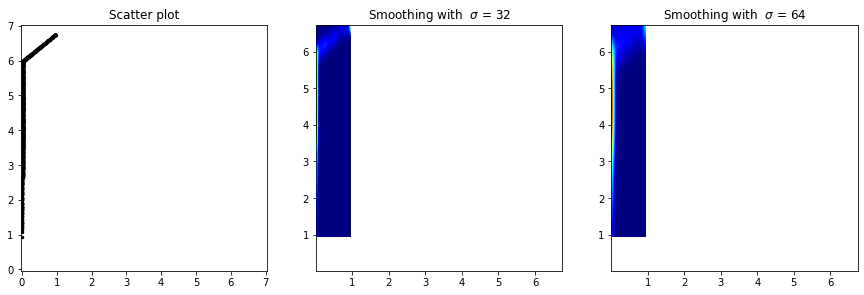

In [24]:
plot.bivariate_hist(recoded)

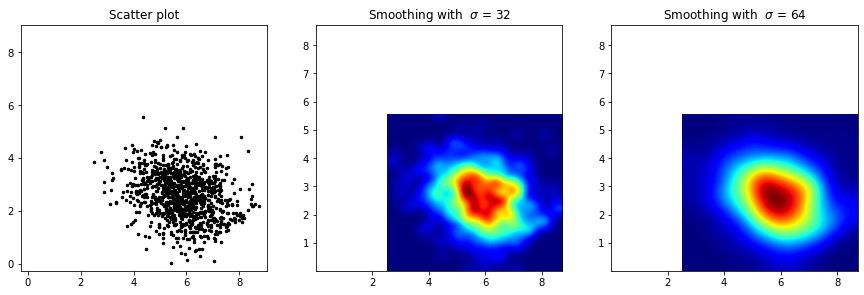

In [25]:
plot.bivariate_hist(out)

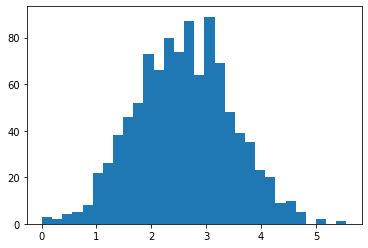

In [26]:
_ = plt.hist(out[:, 1], bins=30)

In [27]:
# n_iter = conf_mlp["train_kernel"]["n_iter"]
# # ksd_kernel = np.split(rundata_mlp["ksd_after_kernel_update"], n_iter)
# # ksd_svgd = np.split(rundata_mlp["ksd_after_svgd_update"], n_iter)
# ksd_kernel = rundata_mlp["ksd_after_kernel_update"]

#     ax.plot(ksdss)


# for i, ksds in enumerate(ksd_kernel):
#     idx = range(40*i, 40*i+20)
# #     print("k range:", idx)
#     ax.plot(idx, ksds, ".b")

# for i, ksds in enumerate(ksd_svgd):
#     start = 40*(i+1) - 20
#     stop = 40*(i+1)
#     step = 5
#     idx = range(start, stop, step)
# #     print("s range:", idx)
#     ax.plot(idx, ksds, ".r")
